In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


In [3]:
glcm_df = pd.read_csv("glcm_daun_herbal.csv")

In [4]:
glcm_df.head()

,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,...,contrast_135,ASM_0,ASM_45,ASM_90,ASM_135,energy_0,energy_45,energy_90,energy_135,label
0,2.155169,2.128282,1.573778,1.981850,0.967856,0.968296,0.978797,0.971387,0.893934,0.894107,...,206.403732,0.763425,0.762476,0.766349,0.763393,0.873742,0.873199,0.875414,0.873724,bayammerah
1,2.745543,2.729991,2.339797,2.704391,0.971795,0.971995,0.976990,0.971445,0.858538,0.858274,...,280.614535,0.699412,0.698212,0.701420,0.698322,0.836309,0.835591,0.837508,0.835656,bayammerah
2,2.219886,2.064053,1.734089,2.158455,0.970180,0.972196,0.978479,0.972099,0.876588,0.878963,...,179.520198,0.733340,0.732640,0.736039,0.732738,0.856353,0.855944,0.857927,0.856001,bayammerah
3,1.874893,1.774563,1.251114,1.723493,0.958155,0.961688,0.976334,0.962554,0.926994,0.927510,...,210.880696,0.837070,0.836777,0.840154,0.837105,0.914915,0.914755,0.916599,0.914935,bayammerah
4,2.632338,2.512820,2.098180,2.619050,0.971990,0.973222,0.979232,0.972380,0.855074,0.857443,...,308.611378,0.679195,0.678312,0.681694,0.678015,0.824133,0.823597,0.825647,0.823416,bayammerah


In [5]:
label_distr = glcm_df['label'].value_counts()

label_name = ['bayammerah','binahongmerah','insulin','jambubiji','jarak', 'katuk', 'kembangsepatu', 'kumiskucing', 'mangkok', 'salam', 'seri', 'sirihmerah', 'sirsak', 'tapakdara', 'urangaring']


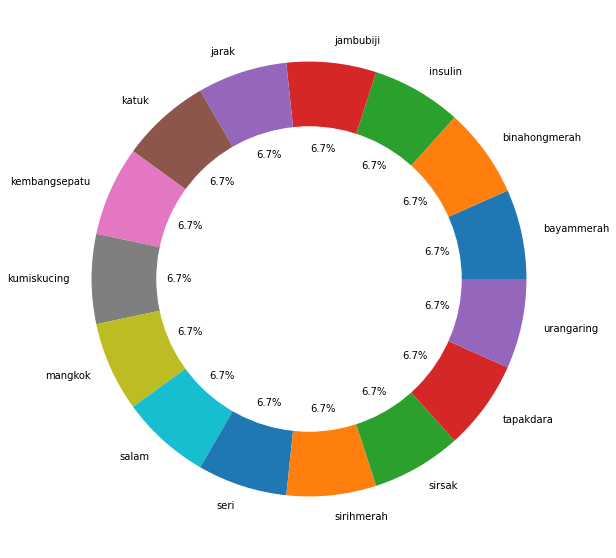

In [6]:
plt.figure(figsize=(20,10))

my_circle = plt.Circle( (0,0), 0.7, color='white')
plt.pie(label_distr, 
        labels=label_name,  
        autopct='%1.1f%%')

p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [7]:
print(label_distr)

sirsak           30
sirih            30
jarak            30
seri             30
jambubiji        30
bayammerah       30
binahongmerah    30
mangkok          30
katuk            30
kumiskucing      30
kembangsepatu    30
urangaring       30
insulin          30
salam            30
tapakdara        30
Name: label, dtype: int64


In [8]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [9]:
# ------------------------ Data Normalization menggunakan Decimal Scaling --------------------------------
def decimal_scaling(data):
    data = np.array(data, dtype=np.float32)
    max_row = data.max(axis=0)
    c = np.array([len(str(int(number))) for number in np.abs(max_row)])
    return data/(10**c)

 

In [10]:
X = decimal_scaling(
            glcm_df[['dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 
                     'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 
                     'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 
                     'contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 
                     'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135',
                     'energy_0', 'energy_45', 'energy_90', 'energy_135']].values
                )

In [11]:
le = LabelEncoder()
le.fit(glcm_df["label"].values)


print(" categorical label : \n", le.classes_)

Y = le.transform(glcm_df['label'].values)
Y = to_categorical(Y)

print("\n\n one hot encoding for sample 0 : \n", Y[0])

 categorical label : 
 ['bayammerah' 'binahongmerah' 'insulin' 'jambubiji' 'jarak' 'katuk'
 'kembangsepatu' 'kumiskucing' 'mangkok' 'salam' 'seri' 'sirih' 'sirsak'
 'tapakdara' 'urangaring']


 one hot encoding for sample 0 : 
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [12]:
X_train, X_test, y_train, y_test = \
                    train_test_split(X, 
                                     Y, 
                                     test_size=0.25, 
                                     random_state=42)
  
print("Dimensi data :\n")
print("X train \t X test \t Y train \t Y test")  
print("%s \t %s \t %s \t %s" % (X_train.shape, X_test.shape, y_train.shape, y_test.shape))

Dimensi data :

X train 	 X test 	 Y train 	 Y test
(337, 24) 	 (113, 24) 	 (337, 15) 	 (113, 15)


In [13]:
from keras.models import Sequential
from keras.layers import Dense, Activation

import keras
from keras import backend as K

In [14]:
# --------------------- create custom metric evaluation ---------------------
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [15]:
# --------------------------- create model -------------------------------
def nn_model(max_len):
    
    model = Sequential()
    model.add(Dense(32, 
                    activation="elu",
                    input_shape=(max_len,)))
    model.add(Dense(1024, activation="elu"))
    model.add(Dense(512, activation="elu"))
    model.add(Dense(256, activation="elu"))
    model.add(Dense(128, activation="elu"))
    model.add(Dense(15))
    model.add(Activation("sigmoid"))
    
    model.summary() 
    
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy', precision, recall])

    return model
 

In [16]:
# ------------------------- check model -----------------------------
def check_model(model_, x, y, x_val, y_val, epochs_, batch_size_):

    hist = model_.fit(x, 
                      y,
                      epochs=epochs_,
                      batch_size=batch_size_,
                      validation_data=(x_val,y_val))
    return hist 

In [17]:
max_len = X_train.shape[1]  

EPOCHS = 200
BATCH_SIZE = 32

model = nn_model(max_len)
history=check_model(model, X_train,y_train,X_test,y_test, EPOCHS, BATCH_SIZE)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                800       
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              33792     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 15)                1935      
_________________________________________________________________
activation_1 (Activation)    (None, 15)               

337/337 [==============================] - 0s 598us/step - loss: 1.2175 - accuracy: 0.4777 - precision: 0.5526 - recall: 0.3706 - val_loss: 1.1951 - val_accuracy: 0.4690 - val_precision: 0.5335 - val_recall: 0.3453
Epoch 32/200
337/337 [==============================] - 0s 462us/step - loss: 1.4190 - accuracy: 0.3887 - precision: 0.6380 - recall: 0.3232 - val_loss: 1.2277 - val_accuracy: 0.5133 - val_precision: 0.6930 - val_recall: 0.4024
Epoch 33/200
337/337 [==============================] - 0s 476us/step - loss: 1.1162 - accuracy: 0.5341 - precision: 0.6564 - recall: 0.4132 - val_loss: 1.2834 - val_accuracy: 0.4690 - val_precision: 0.5786 - val_recall: 0.4621
Epoch 34/200
337/337 [==============================] - 0s 488us/step - loss: 1.0314 - accuracy: 0.5519 - precision: 0.5282 - recall: 0.4330 - val_loss: 1.0496 - val_accuracy: 0.5664 - val_precision: 0.4876 - val_recall: 0.3789
Epoch 35/200
337/337 [==============================] - 0s 550us/step - loss: 0.9036 - accuracy: 0.64

Epoch 67/200
337/337 [==============================] - 0s 586us/step - loss: 0.5888 - accuracy: 0.7626 - precision: 0.1944 - recall: 0.8370 - val_loss: 0.8654 - val_accuracy: 0.6460 - val_precision: 0.1710 - val_recall: 0.7405
Epoch 68/200
337/337 [==============================] - 0s 509us/step - loss: 0.6107 - accuracy: 0.7389 - precision: 0.1808 - recall: 0.8705 - val_loss: 0.6918 - val_accuracy: 0.7699 - val_precision: 0.3010 - val_recall: 0.7618
Epoch 69/200
337/337 [==============================] - 0s 524us/step - loss: 0.5728 - accuracy: 0.7745 - precision: 0.2871 - recall: 0.7775 - val_loss: 0.9699 - val_accuracy: 0.6195 - val_precision: 0.3019 - val_recall: 0.6029
Epoch 70/200
337/337 [==============================] - 0s 530us/step - loss: 0.5889 - accuracy: 0.7329 - precision: 0.2938 - recall: 0.7716 - val_loss: 0.6519 - val_accuracy: 0.7522 - val_precision: 0.3010 - val_recall: 0.8209
Epoch 71/200
337/337 [==============================] - 0s 474us/step - loss: 0.5570 - a

Epoch 103/200
337/337 [==============================] - 0s 462us/step - loss: 0.4265 - accuracy: 0.8309 - precision: 0.2749 - recall: 0.8378 - val_loss: 0.6191 - val_accuracy: 0.7699 - val_precision: 0.2247 - val_recall: 0.9111
Epoch 104/200
337/337 [==============================] - 0s 447us/step - loss: 0.4383 - accuracy: 0.8249 - precision: 0.2107 - recall: 0.8743 - val_loss: 0.8721 - val_accuracy: 0.7080 - val_precision: 0.2854 - val_recall: 0.7587
Epoch 105/200
337/337 [==============================] - 0s 453us/step - loss: 0.4859 - accuracy: 0.7893 - precision: 0.2373 - recall: 0.8480 - val_loss: 0.7468 - val_accuracy: 0.7345 - val_precision: 0.1778 - val_recall: 0.8125
Epoch 106/200
337/337 [==============================] - 0s 459us/step - loss: 0.5500 - accuracy: 0.7982 - precision: 0.2405 - recall: 0.8836 - val_loss: 0.8516 - val_accuracy: 0.7345 - val_precision: 0.2491 - val_recall: 0.8639
Epoch 107/200
337/337 [==============================] - 0s 447us/step - loss: 0.481

Epoch 139/200
337/337 [==============================] - 0s 740us/step - loss: 0.3960 - accuracy: 0.8160 - precision: 0.2263 - recall: 0.8946 - val_loss: 0.7898 - val_accuracy: 0.7168 - val_precision: 0.1926 - val_recall: 0.7093
Epoch 140/200
337/337 [==============================] - 0s 565us/step - loss: 0.4828 - accuracy: 0.8249 - precision: 0.2903 - recall: 0.8853 - val_loss: 0.7552 - val_accuracy: 0.7522 - val_precision: 0.3323 - val_recall: 0.8293
Epoch 141/200
337/337 [==============================] - 0s 512us/step - loss: 0.4349 - accuracy: 0.8309 - precision: 0.3115 - recall: 0.8444 - val_loss: 0.6977 - val_accuracy: 0.7611 - val_precision: 0.2560 - val_recall: 0.9059
Epoch 142/200
337/337 [==============================] - 0s 506us/step - loss: 0.3548 - accuracy: 0.8398 - precision: 0.2430 - recall: 0.8738 - val_loss: 0.7522 - val_accuracy: 0.7257 - val_precision: 0.3097 - val_recall: 0.8006
Epoch 143/200
337/337 [==============================] - 0s 515us/step - loss: 0.365

Epoch 175/200
337/337 [==============================] - 0s 512us/step - loss: 0.2682 - accuracy: 0.9050 - precision: 0.3222 - recall: 0.8967 - val_loss: 0.7400 - val_accuracy: 0.7522 - val_precision: 0.3001 - val_recall: 0.9306
Epoch 176/200
337/337 [==============================] - 0s 500us/step - loss: 0.2689 - accuracy: 0.8961 - precision: 0.2757 - recall: 0.9065 - val_loss: 0.6472 - val_accuracy: 0.7611 - val_precision: 0.3332 - val_recall: 0.8587
Epoch 177/200
337/337 [==============================] - 0s 468us/step - loss: 0.2294 - accuracy: 0.9139 - precision: 0.2717 - recall: 0.8932 - val_loss: 0.6845 - val_accuracy: 0.7522 - val_precision: 0.2238 - val_recall: 0.8830
Epoch 178/200
337/337 [==============================] - 0s 524us/step - loss: 0.2430 - accuracy: 0.8991 - precision: 0.2420 - recall: 0.9071 - val_loss: 0.8627 - val_accuracy: 0.7522 - val_precision: 0.2688 - val_recall: 0.8286
Epoch 179/200
337/337 [==============================] - 0s 610us/step - loss: 0.262

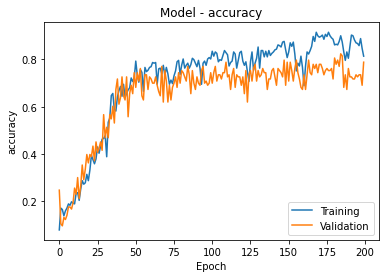

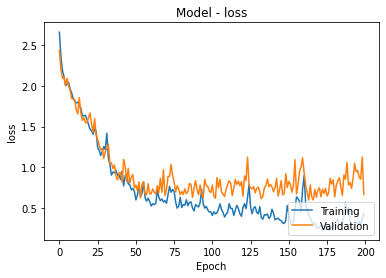

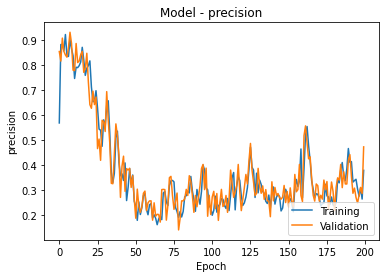

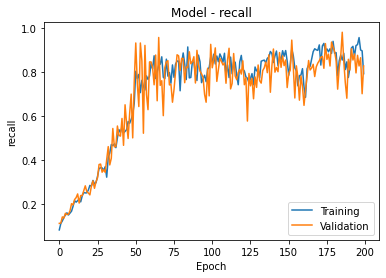

In [18]:

def evaluate_model_(history):
    names = [['accuracy', 'val_accuracy'], 
             ['loss', 'val_loss'], 
             ['precision', 'val_precision'], 
             ['recall', 'val_recall']]
    for name in names :
        fig1, ax_acc = plt.subplots()
        plt.plot(history.history[name[0]])
        plt.plot(history.history[name[1]])
        plt.xlabel('Epoch')
        plt.ylabel(name[0])
        plt.title('Model - ' + name[0])
        plt.legend(['Training', 'Validation'], loc='lower right')
        plt.show()
        
evaluate_model_(history)

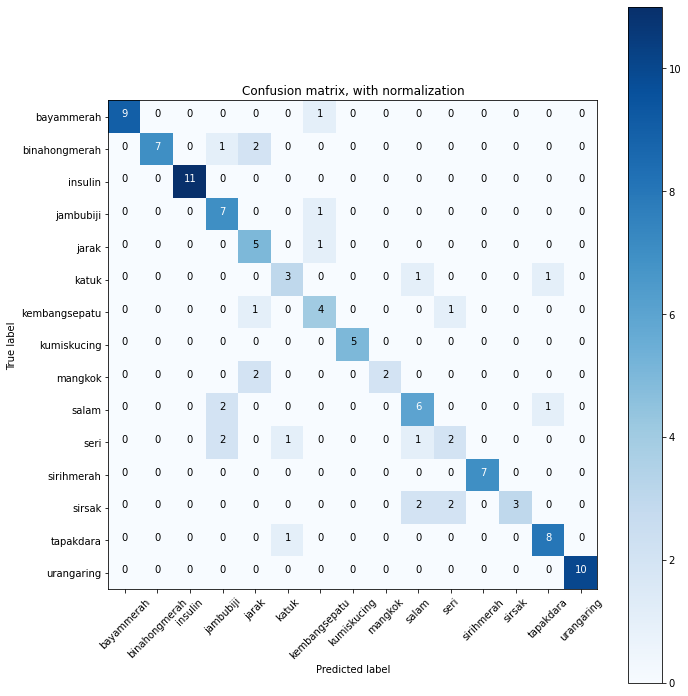

In [19]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
 # predict test data
y_pred=model.predict(X_test)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, 
                      classes=['bayammerah','binahongmerah','insulin','jambubiji','jarak', 'katuk', 'kembangsepatu', 'kumiskucing', 'mangkok', 'salam', 'seri', 'sirihmerah', 'sirsak', 'tapakdara', 'urangaring'],
                      normalize=False,
                      title='Confusion matrix, with normalization')

In [20]:
print(classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=['bayammerah','binahongmerah','insulin','jambubiji','jarak', 'katuk', 'kembangsepatu', 'kumiskucing', 'mangkok', 'salam', 'seri', 'sirihmerah', 'sirsak', 'tapakdara', 'urangaring']))


               precision    recall  f1-score   support

   bayammerah       1.00      0.90      0.95        10
binahongmerah       1.00      0.70      0.82        10
      insulin       1.00      1.00      1.00        11
    jambubiji       0.58      0.88      0.70         8
        jarak       0.50      0.83      0.62         6
        katuk       0.60      0.60      0.60         5
kembangsepatu       0.57      0.67      0.62         6
  kumiskucing       1.00      1.00      1.00         5
      mangkok       1.00      0.50      0.67         4
        salam       0.60      0.67      0.63         9
         seri       0.40      0.33      0.36         6
   sirihmerah       1.00      1.00      1.00         7
       sirsak       1.00      0.43      0.60         7
    tapakdara       0.80      0.89      0.84         9
   urangaring       1.00      1.00      1.00        10

     accuracy                           0.79       113
    macro avg       0.80      0.76      0.76       113
 weighte